<a href="https://colab.research.google.com/github/giuseppemartino26/Semantic-SAM/blob/main/Semantic_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:0

In [ ]:
"""Mean IoU (Intersection-over-Union) metric."""

from typing import Dict, Optional

import datasets
import numpy as np

import evaluate


_DESCRIPTION = """
IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union
between the predicted segmentation and the ground truth. For binary (two classes) or multi-class segmentation,
the mean IoU of the image is calculated by taking the IoU of each class and averaging them.
"""

_KWARGS_DESCRIPTION = """
Args:
    predictions (`List[ndarray]`):
        List of predicted segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    references (`List[ndarray]`):
        List of ground truth segmentation maps, each of shape (height, width). Each segmentation map can be of a different size.
    num_labels (`int`):
        Number of classes (categories).
    ignore_index (`int`):
        Index that will be ignored during evaluation.
    nan_to_num (`int`, *optional*):
        If specified, NaN values will be replaced by the number defined by the user.
    label_map (`dict`, *optional*):
        If specified, dictionary mapping old label indices to new label indices.
    reduce_labels (`bool`, *optional*, defaults to `False`):
        Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
        and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

Returns:
    `Dict[str, float | ndarray]` comprising various elements:
    - *mean_iou* (`float`):
        Mean Intersection-over-Union (IoU averaged over all categories).
    - *mean_accuracy* (`float`):
        Mean accuracy (averaged over all categories).
    - *overall_accuracy* (`float`):
        Overall accuracy on all images.
    - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
        Per category accuracy.
    - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
        Per category IoU.

Examples:

    >>> import numpy as np

    >>> mean_iou = evaluate.load("mean_iou")

    >>> # suppose one has 3 different segmentation maps predicted
    >>> predicted_1 = np.array([[1, 2], [3, 4], [5, 255]])
    >>> actual_1 = np.array([[0, 3], [5, 4], [6, 255]])

    >>> predicted_2 = np.array([[2, 7], [9, 2], [3, 6]])
    >>> actual_2 = np.array([[1, 7], [9, 2], [3, 6]])

    >>> predicted_3 = np.array([[2, 2, 3], [8, 2, 4], [3, 255, 2]])
    >>> actual_3 = np.array([[1, 2, 2], [8, 2, 1], [3, 255, 1]])

    >>> predicted = [predicted_1, predicted_2, predicted_3]
    >>> ground_truth = [actual_1, actual_2, actual_3]

    >>> results = mean_iou.compute(predictions=predicted, references=ground_truth, num_labels=10, ignore_index=255, reduce_labels=False)
    >>> print(results) # doctest: +NORMALIZE_WHITESPACE
    {'mean_iou': 0.47750000000000004, 'mean_accuracy': 0.5916666666666666, 'overall_accuracy': 0.5263157894736842, 'per_category_iou': array([0.   , 0.   , 0.375, 0.4  , 0.5  , 0.   , 0.5  , 1.   , 1.   , 1.   ]), 'per_category_accuracy': array([0.        , 0.        , 0.75      , 0.66666667, 1.        , 0.        , 0.5       , 1.        , 1.        , 1.        ])}
"""

_CITATION = """\
@software{MMSegmentation_Contributors_OpenMMLab_Semantic_Segmentation_2020,
author = {{MMSegmentation Contributors}},
license = {Apache-2.0},
month = {7},
title = {{OpenMMLab Semantic Segmentation Toolbox and Benchmark}},
url = {https://github.com/open-mmlab/mmsegmentation},
year = {2020}
}"""


def intersect_and_union(
    pred_label,
    label,
    num_labels,
    ignore_index: bool,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate intersection and Union.

    Args:
        pred_label (`ndarray`):
            Prediction segmentation map of shape (height, width).
        label (`ndarray`):
            Ground truth segmentation map of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

     Returns:
         area_intersect (`ndarray`):
            The intersection of prediction and ground truth histogram on all classes.
         area_union (`ndarray`):
            The union of prediction and ground truth histogram on all classes.
         area_pred_label (`ndarray`):
            The prediction histogram on all classes.
         area_label (`ndarray`):
            The ground truth histogram on all classes.
    """
    if label_map is not None:
        for old_id, new_id in label_map.items():
            label[label == old_id] = new_id

    # turn into Numpy arrays
    pred_label = np.array(pred_label)
    label = np.array(label)

    if reduce_labels:
        label[label == 0] = 255
        #label = label - 1
        label[label == 254] = 255

    mask = label != ignore_index
    mask = np.not_equal(label, ignore_index)
    pred_label = pred_label[mask]
    label = np.array(label)[mask]

    intersect = pred_label[pred_label == label]

    area_intersect = np.histogram(intersect, bins=num_labels, range=(0, num_labels - 1))[0]
    area_pred_label = np.histogram(pred_label, bins=num_labels, range=(0, num_labels - 1))[0]
    area_label = np.histogram(label, bins=num_labels, range=(0, num_labels - 1))[0]

    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index: bool,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate Total Intersection and Union, by calculating `intersect_and_union` for each (predicted, ground truth) pair.

    Args:
        results (`ndarray`):
            List of prediction segmentation maps, each of shape (height, width).
        gt_seg_maps (`ndarray`):
            List of ground truth segmentation maps, each of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

     Returns:
         total_area_intersect (`ndarray`):
            The intersection of prediction and ground truth histogram on all classes.
         total_area_union (`ndarray`):
            The union of prediction and ground truth histogram on all classes.
         total_area_pred_label (`ndarray`):
            The prediction histogram on all classes.
         total_area_label (`ndarray`):
            The ground truth histogram on all classes.
    """
    total_area_intersect = np.zeros((num_labels,), dtype=np.float64)
    total_area_union = np.zeros((num_labels,), dtype=np.float64)
    total_area_pred_label = np.zeros((num_labels,), dtype=np.float64)
    total_area_label = np.zeros((num_labels,), dtype=np.float64)
    for result, gt_seg_map in zip(results, gt_seg_maps):
        area_intersect, area_union, area_pred_label, area_label = intersect_and_union(
            result, gt_seg_map, num_labels, ignore_index, label_map, reduce_labels
        )
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, total_area_pred_label, total_area_label


def mean_iou(
    results,
    gt_seg_maps,
    num_labels,
    ignore_index: bool,
    nan_to_num: Optional[int] = None,
    label_map: Optional[Dict[int, int]] = None,
    reduce_labels: bool = False,
):
    """Calculate Mean Intersection and Union (mIoU).

    Args:
        results (`ndarray`):
            List of prediction segmentation maps, each of shape (height, width).
        gt_seg_maps (`ndarray`):
            List of ground truth segmentation maps, each of shape (height, width).
        num_labels (`int`):
            Number of categories.
        ignore_index (`int`):
            Index that will be ignored during evaluation.
        nan_to_num (`int`, *optional*):
            If specified, NaN values will be replaced by the number defined by the user.
        label_map (`dict`, *optional*):
            Mapping old labels to new labels. The parameter will work only when label is str.
        reduce_labels (`bool`, *optional*, defaults to `False`):
            Whether or not to reduce all label values of segmentation maps by 1. Usually used for datasets where 0 is used for background,
            and background itself is not included in all classes of a dataset (e.g. ADE20k). The background label will be replaced by 255.

    Returns:
        `Dict[str, float | ndarray]` comprising various elements:
        - *mean_iou* (`float`):
            Mean Intersection-over-Union (IoU averaged over all categories).
        - *mean_accuracy* (`float`):
            Mean accuracy (averaged over all categories).
        - *overall_accuracy* (`float`):
            Overall accuracy on all images.
        - *per_category_accuracy* (`ndarray` of shape `(num_labels,)`):
            Per category accuracy.
        - *per_category_iou* (`ndarray` of shape `(num_labels,)`):
            Per category IoU.
    """
    total_area_intersect, total_area_union, total_area_pred_label, total_area_label = total_intersect_and_union(
        results, gt_seg_maps, num_labels, ignore_index, label_map, reduce_labels
    )

    # compute metrics
    metrics = dict()

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    iou = total_area_intersect / total_area_union
    acc = total_area_intersect / total_area_label

    metrics["mean_iou"] = np.nanmean(iou)
    metrics["mean_accuracy"] = np.nanmean(acc)
    metrics["overall_accuracy"] = all_acc
    metrics["per_category_iou"] = iou
    metrics["per_category_accuracy"] = acc

    if nan_to_num is not None:
        metrics = dict(
            {metric: np.nan_to_num(metric_value, nan=nan_to_num) for metric, metric_value in metrics.items()}
        )

    return metrics


@evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class MeanIoU(evaluate.Metric):
    def _info(self):
        return evaluate.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                # 1st Seq - height dim, 2nd - width dim
                {
                    "predictions": datasets.Sequence(datasets.Sequence(datasets.Value("uint16"))),
                    "references": datasets.Sequence(datasets.Sequence(datasets.Value("uint16"))),
                }
            ),
            reference_urls=[
                "https://github.com/open-mmlab/mmsegmentation/blob/71c201b1813267d78764f306a297ca717827c4bf/mmseg/core/evaluation/metrics.py"
            ],
        )

    def _compute(
        self,
        predictions,
        references,
        num_labels: int,
        ignore_index: bool,
        nan_to_num: Optional[int] = None,
        label_map: Optional[Dict[int, int]] = None,
        reduce_labels: bool = False,
    ):
        iou_result = mean_iou(
            results=predictions,
            gt_seg_maps=references,
            num_labels=num_labels,
            ignore_index=ignore_index,
            nan_to_num=nan_to_num,
            label_map=label_map,
            reduce_labels=reduce_labels,
        )
        return iou_result

In [ ]:
import numpy as np
from PIL import Image
import os
import numpy as np
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import sys
sys.path.append("..")
from google.colab import drive
import csv
import copy
import shutil

from datasets import load_metric

import numpy as np


drive.mount('/content/drive')

#--------CREO CORRISPONDENZA TRA CLASSI PASCAL & ADE20K---------#
class_PASCAL = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

class_ade20k_convertion=[91,128,0,77,99,81,21,0,20,0,0,0,0,117,13,0,0,24,0,0]


using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

def create_vect_dict(masks,total_classes,img_seg):
    """
      Crea un dizionario di vettori per le maschere di segmentazione.

      Args:
          masks (list): Lista delle maschere di segmentazione.
          total_classes (list): Lista delle classi totali.
          img_seg (numpy.ndarray): Array dell'immagine di segmentazione.

      Returns:
          list: Lista di dizionari rappresentanti i vettori per ogni maschera.

      """

    vect_dict = []
    for mask in masks:
        dict_class = dict.fromkeys(total_classes, 0)
        for raw in range(0, len(mask['segmentation'])):
            for col in range(0, len(mask['segmentation'][raw])):
                if mask['segmentation'][raw][col]:
                    dict_class[img_seg[raw][col]] += 1
        vect_dict.append(dict_class)
    return vect_dict


def merge(masks,max_classes,img_seg):
  i = 0
  for mask in masks:
      for raw in range(0, len(mask['segmentation'])):
          for col in range(0, len(mask['segmentation'][raw])):
              if mask['segmentation'][raw][col]:
                  img_seg[raw][col] = max_classes[i]
      i += 1
  return img_seg

def _get_voc_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

vocpallete = _get_voc_pallete(256)

adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

citypallete = [
128,64,128,244,35,232,70,70,70,102,102,156,190,153,153,153,153,153,250,170,30,220,220,0,107,142,35,152,251,152,70,130,180,220,20,60,255,0,0,0,0,142,0,0,70,0,60,100,0,80,100,0,0,230,119,11,32,128,192,0,0,64,128,128,64,128,0,192,128,128,192,128,64,64,0,192,64,0,64,192,0,192,192,0,64,64,128,192,64,128,64,192,128,192,192,128,0,0,64,128,0,64,0,128,64,128,128,64,0,0,192,128,0,192,0,128,192,128,128,192,64,0,64,192,0,64,64,128,64,192,128,64,64,0,192,192,0,192,64,128,192,192,128,192,0,64,64,128,64,64,0,192,64,128,192,64,0,64,192,128,64,192,0,192,192,128,192,192,64,64,64,192,64,64,64,192,64,192,192,64,64,64,192,192,64,192,64,192,192,192,192,192,32,0,0,160,0,0,32,128,0,160,128,0,32,0,128,160,0,128,32,128,128,160,128,128,96,0,0,224,0,0,96,128,0,224,128,0,96,0,128,224,0,128,96,128,128,224,128,128,32,64,0,160,64,0,32,192,0,160,192,0,32,64,128,160,64,128,32,192,128,160,192,128,96,64,0,224,64,0,96,192,0,224,192,0,96,64,128,224,64,128,96,192,128,224,192,128,32,0,64,160,0,64,32,128,64,160,128,64,32,0,192,160,0,192,32,128,192,160,128,192,96,0,64,224,0,64,96,128,64,224,128,64,96,0,192,224,0,192,96,128,192,224,128,192,32,64,64,160,64,64,32,192,64,160,192,64,32,64,192,160,64,192,32,192,192,160,192,192,96,64,64,224,64,64,96,192,64,224,192,64,96,64,192,224,64,192,96,192,192,224,192,192,0,32,0,128,32,0,0,160,0,128,160,0,0,32,128,128,32,128,0,160,128,128,160,128,64,32,0,192,32,0,64,160,0,192,160,0,64,32,128,192,32,128,64,160,128,192,160,128,0,96,0,128,96,0,0,224,0,128,224,0,0,96,128,128,96,128,0,224,128,128,224,128,64,96,0,192,96,0,64,224,0,192,224,0,64,96,128,192,96,128,64,224,128,192,224,128,0,32,64,128,32,64,0,160,64,128,160,64,0,32,192,128,32,192,0,160,192,128,160,192,64,32,64,192,32,64,64,160,64,192,160,64,64,32,192,192,32,192,64,160,192,192,160,192,0,96,64,128,96,64,0,224,64,128,224,64,0,96,192,128,96,192,0,224,192,128,224,192,64,96,64,192,96,64,64,224,64,192,224,64,64,96,192,192,96,192,64,224,192,192,224,192,32,32,0,160,32,0,32,160,0,160,160,0,32,32,128,160,32,128,32,160,128,160,160,128,96,32,0,224,32,0,96,160,0,224,160,0,96,32,128,224,32,128,96,160,128,224,160,128,32,96,0,160,96,0,32,224,0,160,224,0,32,96,128,160,96,128,32,224,128,160,224,128,96,96,0,224,96,0,96,224,0,224,224,0,96,96,128,224,96,128,96,224,128,224,224,128,32,32,64,160,32,64,32,160,64,160,160,64,32,32,192,160,32,192,32,160,192,160,160,192,96,32,64,224,32,64,96,160,64,224,160,64,96,32,192,224,32,192,96,160,192,224,160,192,32,96,64,160,96,64,32,224,64,160,224,64,32,96,192,160,96,192,32,224,192,160,224,192,96,96,64,224,96,64,96,224,64,224,224,64,96,96,192,224,96,192,96,224,192,0,0,0]

def get_mask_pallete(npimg, dataset='detail'):
    """Get image color pallete for visualizing masks"""
    # recovery boundary
    if dataset == 'pascal_voc':
        npimg[npimg==21] = 255
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    if dataset == 'ade20k':
        out_img.putpalette(adepallete)
    elif dataset == 'citys':
        out_img.putpalette(citypallete)
    elif dataset in ('detail', 'pascal_voc', 'pascal_aug'):
        out_img.putpalette(vocpallete)
    return out_img


def write_segm_img(path, image, labels, palette="detail", alpha=0.5):
    """Write depth map to pfm and png file.

    Args:
        path (str): filepath without extension
        image (array): input image
        labels (array): labeling of the image
    """

    mask = get_mask_pallete(labels, "ade20k")

    img = Image.fromarray(np.uint8(255*image)).convert("RGBA")
    seg = mask.convert("RGBA")

    out = Image.blend(img, seg, alpha)

    out.save(path + ".png")

    return


def read_image(path):
    """Read image and output RGB image (0-1).

    Args:
        path (str): path to file

    Returns:
        array: RGB image (0-1)
    """
    img = cv2.imread(path)

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    return img

def ade20k_to_pascalvoc(img_seg):
    for i in range(0, len(img_seg)):
        for j in range(0, len(img_seg[i])):
            if img_seg[i][j] != 0:
                if img_seg[i][j] in class_ade20k_convertion:
                    img_seg[i][j] = class_ade20k_convertion.index(img_seg[i][j]) + 1
                else:
                    img_seg[i][j] = 0
    return img_seg


def dice_coefficient(class_matrix, matrix2):
  intersection = 0
  sum1 = 0
  sum2 = 0
  matrix2[matrix2 == 255] = False

  for i in range(0, len(class_matrix)):
        for j in range(0, len(class_matrix[i])):
          if matrix2[i][j] == class_matrix[i][j] and matrix2[i][j] != 0:
            intersection += 1

          if class_matrix[i][j] != 0 and class_matrix[i][j] != 255:
            sum1 += 1

          if matrix2[i][j] != 0:
            sum2 += 1
          
  dice = (2.0 * intersection) / (sum1 + sum2)
  return dice


def iou(class_matrix, matrix2):
  intersection = 0
  union = 0

  for i in range(0, len(class_matrix)):
        for j in range(0, len(class_matrix[i])):
          if matrix2[i][j] == class_matrix[i][j] and matrix2[i][j] != 0:
            intersection += 1

          if matrix2[i][j] != 0 or (class_matrix[i][j] != 0 and class_matrix[i][j] != 255):
            union += 1

  iou_score = intersection / union
  return iou_score


Mounted at /content/drive
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qcuzf545
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qcuzf545
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=c3663a998af7d2f772606c9f4d502bfe007ea106e04daebba7cd4383aae0e538
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_zxhhj8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc9

In [ ]:
  # Percorso della cartella contenente le immagini
  import time
  import json
  from tqdm import tqdm
  import evaluate

  cartella_immagini = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/'
  # Ottieni la lista dei file nella cartella
  elenco_file = os.listdir(cartella_immagini)
  elenco_file.sort()
  parti = np.array_split(elenco_file, 16)
  # Loop attraverso tutti i file nella cartella
  
  dict_metrics= {} 
  #peppe:parti0 , 1, 2,3,4,5,6,7
  #salvo: 8,9,10,11,12,13,14,15 
  part = 14
  for img_name in tqdm(parti[part]):
      iou_sem_sam = {}
      dice_sem_sam = {}
      iou_sem = {}
      dice_sem = {}
      m_iou_sem = {}
      m_iou_sem_sam = {}
      img_name = img_name[:img_name.rindex(".")]
    
      matrix_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/img_matrix/{img_name}.npy'  # semantic segmentation predictions
      img_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/{img_name}'
      ground_truth = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/{img_name}'
      dir_output = f"/content/drive/MyDrive/results_only_match/output/{img_name}"
      # Verifica se la cartella esiste già
      if os.path.exists(dir_output):
          # Elimina la cartella se esiste già
          shutil.rmtree(dir_output)


      # Crea la cartella
      os.mkdir(dir_output)

      # Carica l'immagine di segmentazione true
      image_path = ground_truth
      segmentation_true = Image.open(f"{image_path}.png")

      #image_rgb = segmentation_true.convert("RGB")


      # Salva l'immagine nella cartella specificata
      #image_save_path = os.path.join(dir_output, "segmentation_true.jpg")
      #image_rgb.save(image_save_path)

      # Converti l'immagine in una matrice numpy
      segmentation_array = np.array(segmentation_true)

      #----1)-----------DICHIARO LA MATRICE CHE CONTIENE LE CLASSI DELLA SEGMENTATION TRUTH----------#
      # Mappa i valori dei pixel agli indici di classe (0-20)
      class_matrix = segmentation_array.astype(int)

      #controllo se nell'immagine di segmentazione truth è vuota per ADE20K
      class_sem = np.unique(class_matrix)[1:-1]
      exist_class_sem = 0
      for a in class_sem:
        if class_ade20k_convertion[a - 1] == 0:
          exist_class_sem += 1
      if exist_class_sem > 0:
        continue 
      #----2)-----------ESTRAGGO LE IMMAGINI DA SEGMENTARE CON SAM------#
      inizio = time.time()
      image = cv2.imread(f"{img_path}.jpg")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      masks = mask_generator.generate(image) # all model mask

      plt.figure(figsize=(20, 20))
      plt.imshow(image)
      show_anns(masks)
      plt.axis('off')

      plt.savefig(f'{dir_output}/SAM.png')
      fine = time.time()
      tempo_di_esecuzione_sam = fine - inizio

      #----3)----------CARICHIAMO LA MATRICE DELLA PREDIZIONE SEMANTICA---------#

      img_seg = np.load(matrix_path)
      img_seg_dpt = copy.copy(img_seg)
      """
      if os.path.isfile(f"/content/drive/MyDrive/ProgettoSEAI/data/output_semseg/{img_name}.png"):
          # Sposta l'immagine nella cartella di destinazione
          shutil.copy(f"/content/drive/MyDrive/ProgettoSEAI/data/output_semseg/{img_name}.png", f"{dir_output}/semantic.png")
      else:
         print("L'immagine di origine non esiste.")
      """

      #----4)---------MERGIAMO SEMANTICA E SAM----------------#
      inizio = time.time()

      total_classes = np.unique(img_seg_dpt)
      dict_class = dict.fromkeys(total_classes, 0)

      # Popoliamo un dict_class per ogni maschera dell'immagine. vect_dict è un array di dict_class

      vect_dict = create_vect_dict(masks,total_classes,img_seg)

      max_classes = []  # la classe di ogni maschera
      for dict_mask in vect_dict:
          max_classes.append(max(dict_mask, key=dict_mask.get))

      img_seg = merge(masks,max_classes,img_seg)

      img = read_image(f"{img_path}.jpg")
      write_segm_img(f'{dir_output}/sem_plus_sam', img, img_seg, alpha=0.5)
      
      fine = time.time()
      tempo_di_esecuzione_sam_sem = fine - inizio
      #ADE20K to PASCAL_VOC
      matrix_sem_plus_sam= ade20k_to_pascalvoc(img_seg)

      matrix_only_sem = ade20k_to_pascalvoc(img_seg_dpt)

      

      iou_sem_sam["iou_sem_sam"] = iou(class_matrix, matrix_sem_plus_sam)
      dice_sem_sam["dice_sem_sam"] = dice_coefficient(class_matrix, matrix_sem_plus_sam)
      iou_sem["iou_sem"] = iou(class_matrix, matrix_only_sem)
      dice_sem["dice_sem"] = dice_coefficient(class_matrix, matrix_only_sem)
      m_iou_sem["m_iou_sem"] = mean_iou(matrix_only_sem, class_matrix, num_labels=150, ignore_index=255)["mean_iou"]
      m_iou_sem_sam["m_iou_sem_sam"] = mean_iou(matrix_sem_plus_sam, class_matrix, num_labels=150, ignore_index=255)["mean_iou"]
      dict_metrics[img_name] = [iou_sem_sam,dice_sem_sam,iou_sem,dice_sem,m_iou_sem,m_iou_sem_sam]
      plt.close('all')

    

      


          
  
  with open(f"/content/drive/MyDrive/results_only_match/metriche/dict_metrics{part}.json", "w") as file:
    #Scrivi il dizionario nel file in formato JSON
    json.dump(dict_metrics, file)
 
  

  0%|          | 0/90 [00:00<?, ?it/s]<ipython-input-2-1a1af0960f2e>:246: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-2-1a1af0960f2e>:247: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
100%|██████████| 90/90 [14:27<00:00,  9.63s/it]


#Solo per il report

In [ ]:
  # Percorso della cartella contenente le immagini
  import time
  import json
  from tqdm import tqdm
  import evaluate

  cartella_immagini = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/'
  # Ottieni la lista dei file nella cartella
  elenco_file = os.listdir(cartella_immagini)
  elenco_file.sort()
  parti = np.array_split(elenco_file, 16)
  # Loop attraverso tutti i file nella cartella
  
  dict_metrics= {} 
  #peppe:parti0 , 1, 2,3,4,5,6,7
  #salvo: 8,9,10,11,12,13,14,15 
  part = 14
  for img_name in tqdm(parti[part]):
      iou_sem_sam = {}
      dice_sem_sam = {}
      iou_sem = {}
      dice_sem = {}
      m_iou_sem = {}
      m_iou_sem_sam = {}
      img_name = img_name[:img_name.rindex(".")]
    
      matrix_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/img_matrix/2007_000129.npy'  # semantic segmentation predictions
      img_path = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/2007_000129'
      ground_truth = f'/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/2007_000129'
      #dir_output = f"/content/drive/MyDrive/results_only_match/output/2007_000129"
      # Verifica se la cartella esiste già
      #if os.path.exists(dir_output):
          # Elimina la cartella se esiste già
          #shutil.rmtree(dir_output)


      # Crea la cartella
      #os.mkdir(dir_output)

      # Carica l'immagine di segmentazione true
      image_path = ground_truth
      segmentation_true = Image.open(f"{image_path}.png")

      #image_rgb = segmentation_true.convert("RGB")


      # Salva l'immagine nella cartella specificata
      #image_save_path = os.path.join(dir_output, "segmentation_true.jpg")
      #image_rgb.save(image_save_path)

      # Converti l'immagine in una matrice numpy
      segmentation_array = np.array(segmentation_true)

      #----1)-----------DICHIARO LA MATRICE CHE CONTIENE LE CLASSI DELLA SEGMENTATION TRUTH----------#
      # Mappa i valori dei pixel agli indici di classe (0-20)
      class_matrix = segmentation_array.astype(int)

      #controllo se nell'immagine di segmentazione truth è vuota per ADE20K
      class_sem = np.unique(class_matrix)[1:-1]
      exist_class_sem = 0
      for a in class_sem:
        if class_ade20k_convertion[a - 1] == 0:
          exist_class_sem += 1
      if exist_class_sem > 0:
        continue 
      #----2)-----------ESTRAGGO LE IMMAGINI DA SEGMENTARE CON SAM------#
      inizio = time.time()
      image = cv2.imread(f"{img_path}.jpg")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      masks = mask_generator.generate(image) # all model mask

      plt.figure(figsize=(20, 20))
      plt.imshow(image)
      show_anns(masks)
      plt.axis('off')

      #plt.savefig(f'{dir_output}/SAM.png')
      fine = time.time()
      tempo_di_esecuzione_sam = fine - inizio

      #----3)----------CARICHIAMO LA MATRICE DELLA PREDIZIONE SEMANTICA---------#

      img_seg = np.load(matrix_path)
      img_seg_dpt = copy.copy(img_seg)
      """
      if os.path.isfile(f"/content/drive/MyDrive/ProgettoSEAI/data/output_semseg/{img_name}.png"):
          # Sposta l'immagine nella cartella di destinazione
          shutil.copy(f"/content/drive/MyDrive/ProgettoSEAI/data/output_semseg/{img_name}.png", f"{dir_output}/semantic.png")
      else:
         print("L'immagine di origine non esiste.")
      """

      #----4)---------MERGIAMO SEMANTICA E SAM----------------#
      inizio = time.time()

      total_classes = np.unique(img_seg_dpt)
      dict_class = dict.fromkeys(total_classes, 0)

      # Popoliamo un dict_class per ogni maschera dell'immagine. vect_dict è un array di dict_class

      vect_dict = create_vect_dict(masks,total_classes,img_seg)

      max_classes = []  # la classe di ogni maschera
      for dict_mask in vect_dict:
          max_classes.append(max(dict_mask, key=dict_mask.get))

      img_seg = merge(masks,max_classes,img_seg)

      img = read_image(f"{img_path}.jpg")
      #write_segm_img(f'{dir_output}/sem_plus_sam', img, img_seg, alpha=0.5)
      
      fine = time.time()
      tempo_di_esecuzione_sam_sem = fine - inizio
      #ADE20K to PASCAL_VOC
      matrix_sem_plus_sam= ade20k_to_pascalvoc(img_seg)

      matrix_only_sem = ade20k_to_pascalvoc(img_seg_dpt)

      

      iou_sem_sam["iou_sem_sam"] = iou(class_matrix, matrix_sem_plus_sam)
      dice_sem_sam["dice_sem_sam"] = dice_coefficient(class_matrix, matrix_sem_plus_sam)
      iou_sem["iou_sem"] = iou(class_matrix, matrix_only_sem)
      dice_sem["dice_sem"] = dice_coefficient(class_matrix, matrix_only_sem)
      m_iou_sem["m_iou_sem"] = mean_iou(matrix_only_sem, class_matrix, num_labels=150, ignore_index=255)["mean_iou"]
      m_iou_sem_sam["m_iou_sem_sam"] = mean_iou(matrix_sem_plus_sam, class_matrix, num_labels=150, ignore_index=255)["mean_iou"]
      dict_metrics[img_name] = [iou_sem_sam,dice_sem_sam,iou_sem,dice_sem,m_iou_sem,m_iou_sem_sam]
      plt.close('all')

      break

    

      


          
  
  #with open(f"/content/drive/MyDrive/results_only_match/metriche/dict_metrics{part}.json", "w") as file:
    #Scrivi il dizionario nel file in formato JSON
    #json.dump(dict_metrics, file)
 
  

  0%|          | 0/90 [00:00<?, ?it/s]<ipython-input-2-1a1af0960f2e>:246: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-2-1a1af0960f2e>:247: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
  0%|          | 0/90 [00:24<?, ?it/s]


In [ ]:
tempo_di_esecuzione_sam_sem

5.9930925369262695

In [ ]:
mask_sem = get_mask_pallete(matrix_only_sem, "pascal_voc")
img_sem = mask_sem.convert("RGBA")

mask_sem_sam = get_mask_pallete(matrix_sem_plus_sam, "pascal_voc")
img_sem_sam = mask_sem_sam.convert("RGBA")

In [ ]:
np.save(f"/content/drive/MyDrive/ProgettoSEAI/output/2007_000129/sem_mask_sem_sam.npy", img_sem)

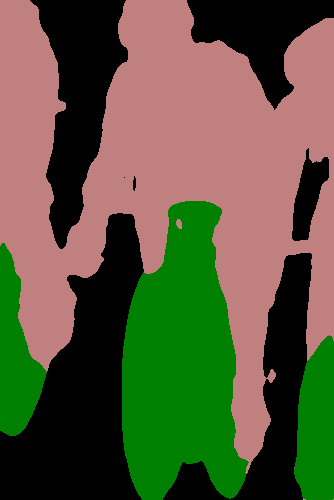

In [ ]:
img_sem

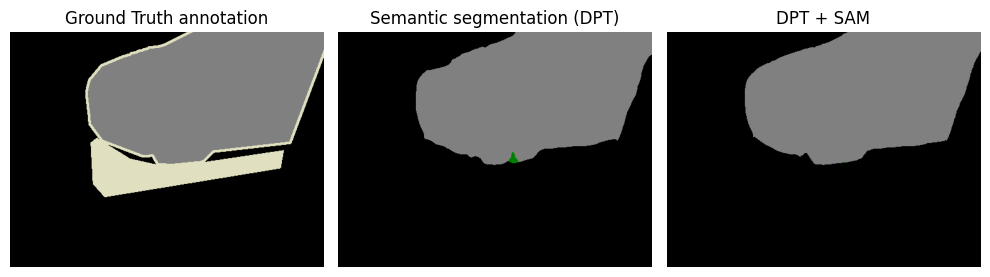

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Crea una griglia di sottoplot 1x3
fig, axes = plt.subplots(1, 3, figsize=(10, 8))

# Visualizza le immagini nei sottoplot
axes[0].imshow(segmentation_true)
axes[0].axis('off')
axes[0].set_title("Ground Truth annotation")

axes[1].imshow(img_sem)
axes[1].axis('off')
axes[1].set_title("Semantic segmentation (DPT)")

axes[2].imshow(img_sem_sam)
axes[2].axis('off')
axes[2].set_title("DPT + SAM")

# Regola automaticamente il layout dei sottoplot
plt.tight_layout()

# Mostra il plot
plt.show()


In [ ]:
type(seg)

PIL.Image.Image

In [ ]:
print(tempo_di_esecuzione_sam_sem)
print(tempo_di_esecuzione_sam)

12.920941591262817
8.711585521697998


In [ ]:
print(f"DICE segmentazione finale: {dice_coefficient(class_matrix,img_seg)}")
print(f"IOU segmentazione finale: {iou(class_matrix,img_seg)}")
print(f"DICE segmentazione semantica: {dice_coefficient(class_matrix,img_seg_dpt)}")
print(f"IOU segmentazione semantica: {iou(class_matrix,img_seg_dpt)}")
print(mean_iou(matrix_sem_plus_sam, class_matrix, num_labels=10, ignore_index=255, reduce_labels=True)["mean_iou"])
print(mean_iou(matrix_only_sem, class_matrix, num_labels=10, ignore_index=255, reduce_labels=True)["mean_iou"])

DICE segmentazione finale: 0.8379192890483733
IOU segmentazione finale: 0.721050853999807
DICE segmentazione semantica: 0.8514332087064893
IOU segmentazione semantica: 0.7413005627192207
0.48306235252286905
0.4747874713126677


<ipython-input-2-1a1af0960f2e>:246: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-2-1a1af0960f2e>:247: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [ ]:
np.unique(matrix_sem_plus_sam)

array([0, 1, 7])

In [ ]:
metrica = MeanIoU()

In [ ]:

#mean_iou = evaluate.load("mean_iou")
predicted = np.array([[0, 0, 5], [0, 1, 2], [0, 0, 0]])
ground_truth = np.array([[0, 0, 4], [0, 2, 2], [0, 0, 255]])
results = mean_iou(predicted,ground_truth, num_labels=150, ignore_index=255, reduce_labels=True)

<ipython-input-112-1a1af0960f2e>:246: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
<ipython-input-112-1a1af0960f2e>:247: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [ ]:
results['mean_iou']

0.125

In [ ]:
iou(predicted, ground_truth)

0.3333333333333333

In [ ]:
import numpy as np

# input
arr1 = [1, 0, False, 4]
arr2 = [2, 5, 0, False]

# output
out_arr = np.logical_or(arr1, arr2)

print ("Output Array : ", out_arr)

Output Array :  [ True  True False  True]
